In [1]:
# Import all the libraries
import re 
import nltk
import numpy as np  
import pandas as pd 
import contractions
from bs4 import BeautifulSoup 
from keras import backend as K
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from attention import AttentionLayer
from tensorflow.keras.models import Model
from keras.preprocessing.text import Tokenizer 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Concatenate

# Import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rashi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read the data set
data = pd.read_csv("C:/Users/rashi/Downloads/AFFR/Reviews.csv", nrows=100000, usecols=['Summary','Text'])

# Drop duplicates and NA values
data.drop_duplicates(subset=['Text'], inplace=True)  
data.dropna(axis=0, inplace=True)

# Print the data
data.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Data pre-processing
def text_preprocessing(text):
    cleanText = text.lower()                                                 #convert the text to lower case
    cleanText = BeautifulSoup(cleanText, "lxml").text                        #extract plain text 
    cleanText = re.sub(r'\([^)]*\)', '', cleanText)                          #remove text between brackets
    cleanText = re.sub('"','', cleanText)                                    #remove quotes
    cleanText = contractions.fix(cleanText)                                  #fix contractions
    cleanText = re.sub(r"'s\b","",cleanText)                                 #remove 's from text
    cleanText = re.sub("[^a-zA-Z]", " ", cleanText)                          #remove punctuations, special characters and digits
    tokens = [w for w in cleanText.split() if not w in stop_words]           #remove stopwords
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                         #remove short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [4]:
# Clean the review text
cleaned_text = []
for rowData in data['Text']:
    cleaned_text.append(text_preprocessing(rowData))

# Clean the review summary
cleaned_summary = []
for rowData in data['Summary']:
    cleaned_summary.append(text_preprocessing(rowData))

# Update the data set
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary

# Drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

# Print the data
data.head()

C:\Users\rashi\Anaconda3\envs\deeplearning\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "cookies" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\rashi\Anaconda3\envs\deeplearning\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\rashi\Anaconda3\envs\deeplearning\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


,Summary,Text,cleaned_text,cleaned_summary
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,good quality dog food
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,advertised
2,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,delight says
3,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,cough medicine
4,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,great taffy


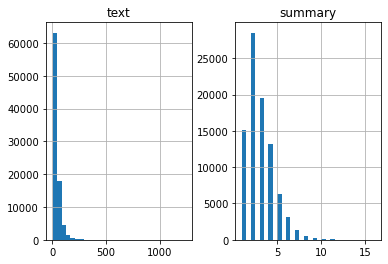

In [5]:
# Exploratory Data Analysis
cleaned_text_wordcount = []
cleaned_summary_wordcount = []

# Populate the lists with sentence lengths
for rowData in data['cleaned_text']:
      cleaned_text_wordcount.append(len(rowData.split()))

for rowData in data['cleaned_summary']:
      cleaned_summary_wordcount.append(len(rowData.split()))

# Plot histogram
wordcount_df = pd.DataFrame({'text':cleaned_text_wordcount, 'summary':cleaned_summary_wordcount})
wordcount_df.hist(bins = 30)
plt.show()

In [6]:
# Fix maximum review text and summary lengths
max_len_text = 40 
max_len_summary = 5

# Filter the text and summary based on the above maximum lengths
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

# Store the filtered data in a dataframe
df=pd.DataFrame({'text':short_text,'summary':short_summary})

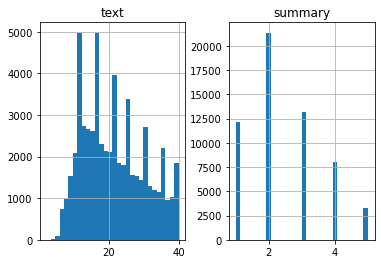

In [7]:
# Exploratory Data Analysis of filtered data
cleaned_text_wordcount = []
cleaned_summary_wordcount = []

# Populate the lists with sentence lengths
for rowData in df['text']:
      cleaned_text_wordcount.append(len(rowData.split()))

for rowData in df['summary']:
      cleaned_summary_wordcount.append(len(rowData.split()))

# Plot histogram
filtered_wordcount_df = pd.DataFrame({'text':cleaned_text_wordcount, 'summary':cleaned_summary_wordcount})
filtered_wordcount_df.hist(bins = 30)
plt.show()

In [8]:
# Delete unnecessary dataframes
del data, wordcount_df, filtered_wordcount_df

In [9]:
# Add start and end tokens to the summary
df['summary'] = df['summary'].apply(lambda x : '_START_ '+ x + ' _END_')

# Print the data
df.head()

,text,summary
0,bought several vitality canned dog food produc...,_START_ good quality dog food _END_
1,product arrived labeled jumbo salted peanuts p...,_START_ advertised _END_
2,confection around centuries light pillowy citr...,_START_ delight says _END_
3,looking secret ingredient robitussin believe f...,_START_ cough medicine _END_
4,great taffy great price wide assortment yummy ...,_START_ great taffy _END_


In [10]:
# Print df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57861 entries, 0 to 57860
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     57861 non-null  object
 1   summary  57861 non-null  object
dtypes: object(2)
memory usage: 904.2+ KB


In [11]:
# Split the training and testing data in the ratio 80:20
x_train,x_test,y_train,y_test=train_test_split(df['text'],df['summary'],test_size=0.2,random_state=0,shuffle=True) 

In [12]:
# Integer encode training reviews with padding
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
x_train = x_tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train,  maxlen=max_len_text, padding='post')

# Print training reviews vocabulary size
x_vocab_size = len(x_tokenizer.word_index) + 1
print(x_vocab_size)

# Integer encode testing reviews with padding
x_test   =   x_tokenizer.texts_to_sequences(x_test)
x_test   =   pad_sequences(x_test, maxlen=max_len_text, padding='post')

28267


In [13]:
# Integer encode training summary with padding
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))
y_train = y_tokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')

# Print training summary vocabulary size
y_vocab_size = len(y_tokenizer.word_index) + 1
print(y_vocab_size)

# Integer encode training summary with padding
y_test = y_tokenizer.texts_to_sequences(y_test) 
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

9456


In [14]:
K.clear_session()
latent_dim = 300 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_vocab_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

#LSTM 4 
encoder_lstm4 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c = encoder_lstm4(encoder_output3) 

# Set up the decoder 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_vocab_size, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

#Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 300)      8480100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 300), (N 721200      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 40, 300), (N 721200      lstm[0][0]                       
_______________________________________________________________________________________

In [15]:
# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=30, callbacks=[es], batch_size=1024, validation_data=([x_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/30
46/46 [==============================] - 401s 9s/step - loss: 5.3363 - val_loss: 4.0613
Epoch 2/30
46/46 [==============================] - 397s 9s/step - loss: 4.1055 - val_loss: 3.7450
Epoch 3/30
46/46 [==============================] - 397s 9s/step - loss: 3.9206 - val_loss: 3.6606
Epoch 4/30
46/46 [==============================] - 397s 9s/step - loss: 3.8049 - val_loss: 3.6150
Epoch 5/30
46/46 [==============================] - 396s 9s/step - loss: 3.7256 - val_loss: 3.5785
Epoch 6/30
46/46 [==============================] - 397s 9s/step - loss: 3.6671 - val_loss: 3.5573
Epoch 7/30
46/46 [==============================] - 395s 9s/step - loss: 3.6115 - val_loss: 3.5289
Epoch 8/30
46/46 [==============================] - 396s 9s/step - loss: 3.5536 - val_loss: 3.5144
Epoch 9/30
46/46 [==============================] - 401s 9s/step - loss: 3.4965 - val_loss: 3.4817
Epoch 10/30
46/46 [==============================] - 396s 9s/step - loss: 3.4259 - val_loss: 3.4356
Epoch 11/

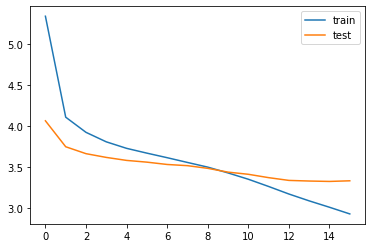

In [16]:
# Plot the test and train loss
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [17]:
# Prepare dictionary to convert back to text
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [18]:
# Final encoder model
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [19]:
# Generate a summary for the input sequence 
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [20]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [21]:
for i in range(20):
  print("Review:",seq2text(x_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_len_text)))
  print("\n")

Review: received shipment house blend coffee late morning within short time brewed pot opened oz package aroma dry coffee rich cup brewed coffee tasted bold rich would highly recommend product 
Original summary: excellent tasting coffee 
Predicted summary:  great coffee


Review: product good gave star poor packaging broken cookies 
Original summary: poor packaging 
Predicted summary:  great gift


Review: discovered product couple years ago really liked taste coffee tea fruit oatmeal lot less expensive packets switched large oz container price good use sugar helps sweet increased blood sugar yeah 
Original summary: best taste ever 
Predicted summary:  great tea


Review: waste money machine waste money got gift makers ripoff artists would made easy put coffee like keurig product lot marketing hype even remotely worth money 
Original summary: waste money 
Predicted summary:  disappointed


Review: stash teas tasty flavours rich full bodied enjoy cup alone friends remember live present 